<a href="https://colab.research.google.com/github/Torikul385/ComputerVision/blob/Image-Enhancement/Enhanced_Deep_Residual_Networks_single_image_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers


AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
div2k = tfds.image.Div2k(config="bicubic_x4")
div2k.download_and_prepare()
train = div2k.as_dataset(split='train', as_supervised=True)
train_cache = train.cache()

val = div2k.as_dataset(split='validation', as_supervised=True)
val_cache = val.cache()

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteCT0ZJF/div2k-train.tfrecord*...:   0%|   …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteCT0ZJF/div2k-validation.tfrecord*...:   0…

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


The high resolution image is 4 times in height and width

In [34]:
def flip_left_right(low_res, high_res):

    n = tf.random.uniform((), maxval=1)
    return tf.cond(
        n<0.5,
        lambda : (low_res, high_res),
        lambda: (
            tf.image.flip_left_right(low_res),
            tf.image.flip_left_right(high_res)
        )
    )

def random_rotate(lowres, highres):
    rn = tf.random.uniform((),maxval=4, dtype=tf.int32)
    return tf.image.rot90(lowres, rn),  tf.image.rot90(highres, rn)


def random_crop(lowres_img, highres_img, hr_crop_size = 96, scale=4):

    lowres_crop_size = hr_crop_size // scale # 96 //4 = 24


    lowres_img_shape = tf.shape(lowres_img)[:2]

    # print(lowres_img_shape[0], lowres_img_shape[0])


    lowres_h_crop_offset = tf.random.uniform(
        (), maxval = lowres_img_shape[0] - lowres_crop_size + 1,
        dtype=tf.int32
    )


    lowres_w_crop_offset = tf.random.uniform(
        (), maxval = lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_h_crop_offset = lowres_h_crop_offset * scale
    highres_w_crop_offset = lowres_w_crop_offset * scale

    lowres_cropped_img = lowres_img[
        lowres_h_crop_offset : lowres_h_crop_offset + lowres_crop_size,
        lowres_w_crop_offset : lowres_w_crop_offset + lowres_crop_size
    ]

    highres_cropped_img = highres_img[
        highres_h_crop_offset : highres_h_crop_offset + hr_crop_size,
        highres_w_crop_offset : highres_w_crop_offset + hr_crop_size
    ]

    return lowres_cropped_img, highres_cropped_img






In [37]:

def prepare_ds(dataset_cache, training=True):

    ds = dataset_cache
    ds = ds.map(
        random_crop,
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    ds = ds.batch(16)

    if training:
        # Repeating Data, so that cardinality if dataset becomes infinte
        ds = ds.repeat()
    # prefetching allows later images to be prepared while the current image is being processed
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = prepare_ds(train_cache, training=True)
val_ds = prepare_ds(val_cache, training=False)

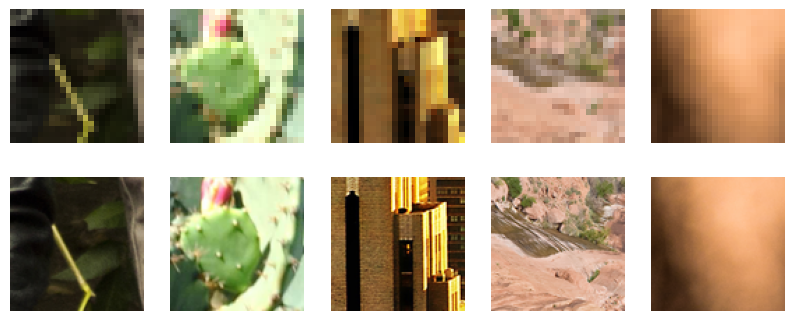

In [46]:
#lowres, highres = next(iter(demo_train_ds))

lowres, highres = next(iter(train_ds))
rows = 2
columns = 5

plt.figure(figsize=(10,4))
for i in range(columns):
    low_img = lowres[i]
    high_img = highres[i]

    plt.subplot(rows, columns, i+1)
    plt.imshow(low_img)
    plt.axis('off')

    plt.subplot(rows, columns, i+columns + 1)
    plt.imshow(high_img)
    plt.axis('off')



In [54]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compiled_loss(y,y_pred, regularization_losses = self.losses)

        train_vars = self.trainable_variables
        grads = tape.gradient(loss, train_vars)
        self.optimizer.apply_gradients(zip(grads, train_vars))
        self.compiled_metrics.update_state(y,y_pred)
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)

        high_img = self(x, training=False)
        high_img = tf.clip_by_value(high_img, 0, 255)
        high_img = tf.round(high_img)

        high_img = tf.squeeze(tf.cast(high_img, tf.uint8), axis=0)

        return high_img



In [55]:
def ResBlock(x_input):
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x_input)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.Add()([x_input, x])
    return x


def Upsampling(inputs, factor = 2, **kwargs):
    x = layers.Conv2D(64 * (factor **2), 3, padding='same', **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size = factor)
    x = layers.Conv2D(64 * (factor **2), 3, padding='same', **kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size = factor)
    return x

def make_model(num_filters, num_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 3))

    x = layers.Rescaling(scale=1.0/255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding='same')(x)

    for _ in range(num_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding='same')(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding='same')(x)

    output_layer = layers.Rescaling(scale=255)(x)

    model = EDSRModel(input_layer, output_layer)
    return model


In [56]:
model = make_model(num_filters = 64, num_residual_blocks = 16)


In [57]:
optim_edsr = keras.optimizers.Adam(
    learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)

def PSNR(pred_img, high_img):
    psnr_value = tf.image.psnr(high_img, pred_img, max_val=255)[0]
    return psnr_value


model.compile(optimizer=optim_edsr, loss='mae', metrics=[PSNR] )



In [58]:
model.fit(train_ds, epochs=50, steps_per_epoch = 200, validation_data = val_ds)

Epoch 1/50
200/200 [==============================] - 31s 78ms/step - loss: 25.9942 - PSNR: 21.1586 - val_loss: 14.7913 - val_PSNR: 21.0833
Epoch 2/50
200/200 [==============================] - 5s 27ms/step - loss: 13.5737 - PSNR: 26.3295 - val_loss: 11.0830 - val_PSNR: 24.1913
Epoch 3/50
200/200 [==============================] - 6s 29ms/step - loss: 11.6679 - PSNR: 28.8553 - val_loss: 9.7246 - val_PSNR: 26.2704
Epoch 4/50
200/200 [==============================] - 5s 25ms/step - loss: 11.2742 - PSNR: 29.5711 - val_loss: 10.8338 - val_PSNR: 26.5882
Epoch 5/50
200/200 [==============================] - 6s 28ms/step - loss: 10.6429 - PSNR: 29.6216 - val_loss: 9.6688 - val_PSNR: 29.4054
Epoch 6/50
200/200 [==============================] - 5s 26ms/step - loss: 10.2123 - PSNR: 30.3136 - val_loss: 9.4738 - val_PSNR: 27.9407
Epoch 7/50
200/200 [==============================] - 7s 33ms/step - loss: 10.1081 - PSNR: 31.2200 - val_loss: 9.2097 - val_PSNR: 28.2051
Epoch 8/50
200/200 [==========

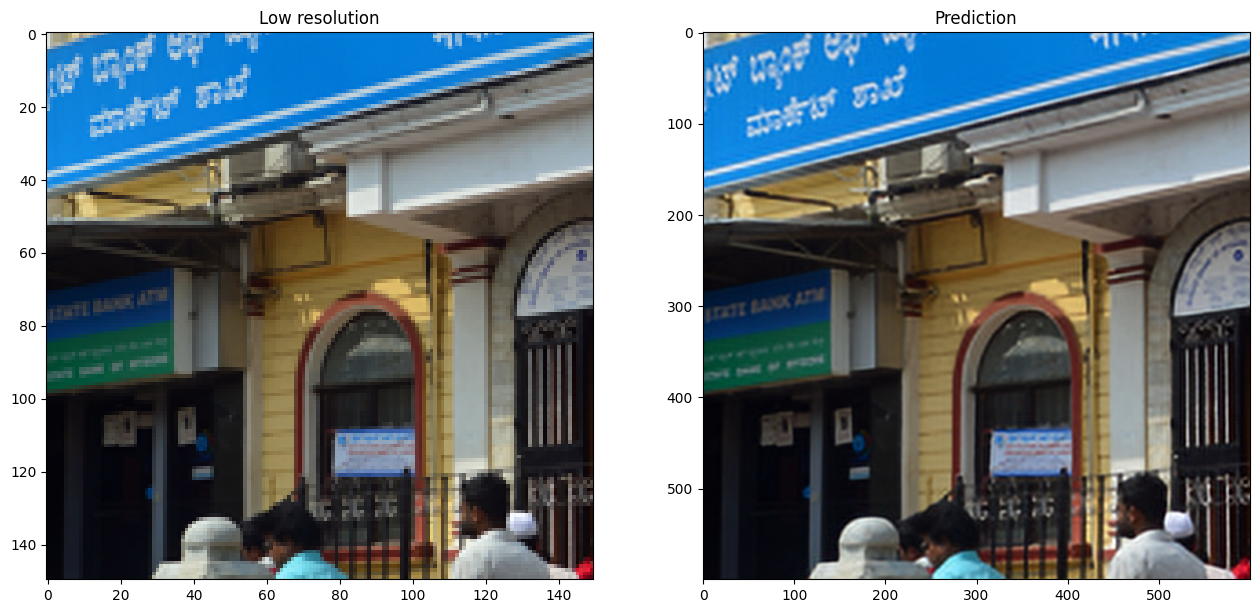

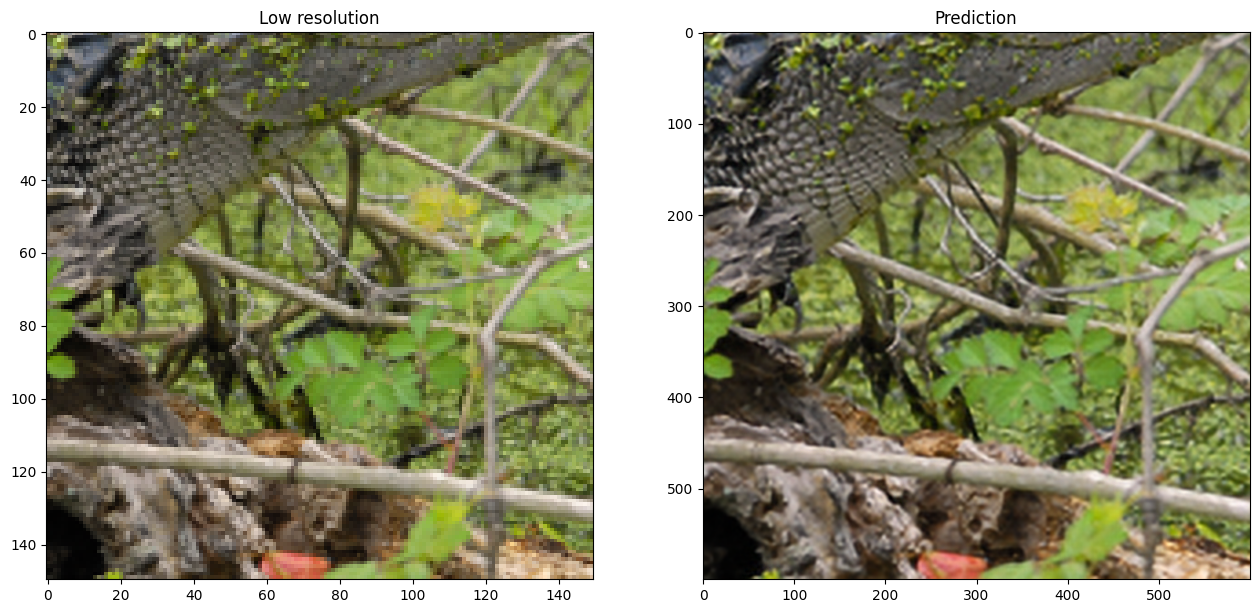

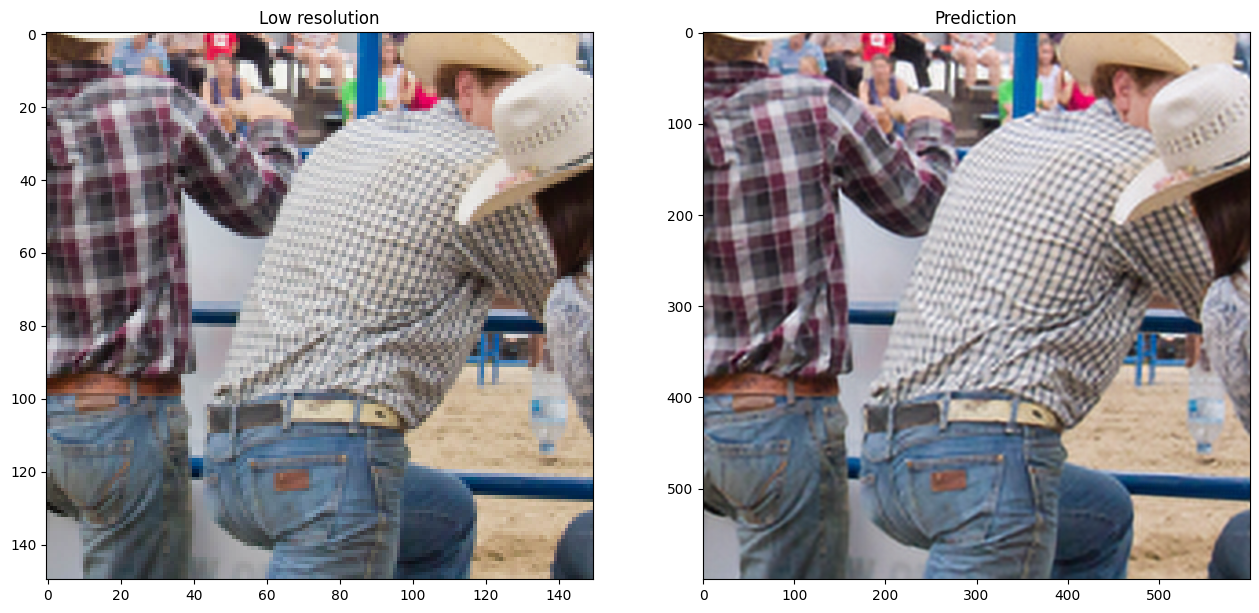

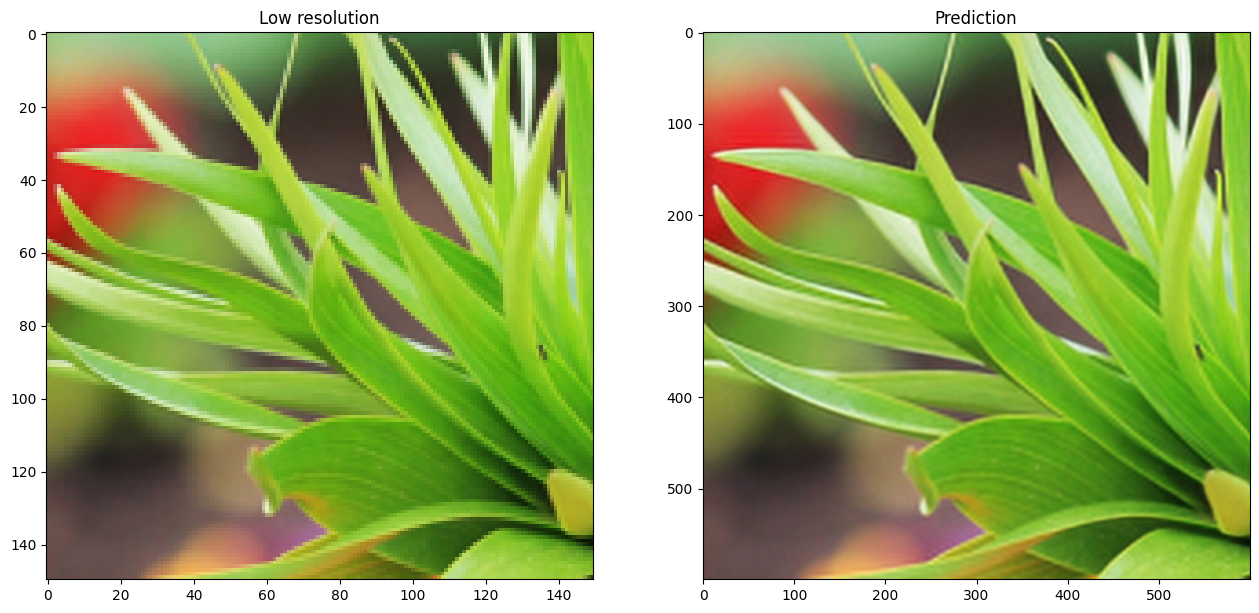

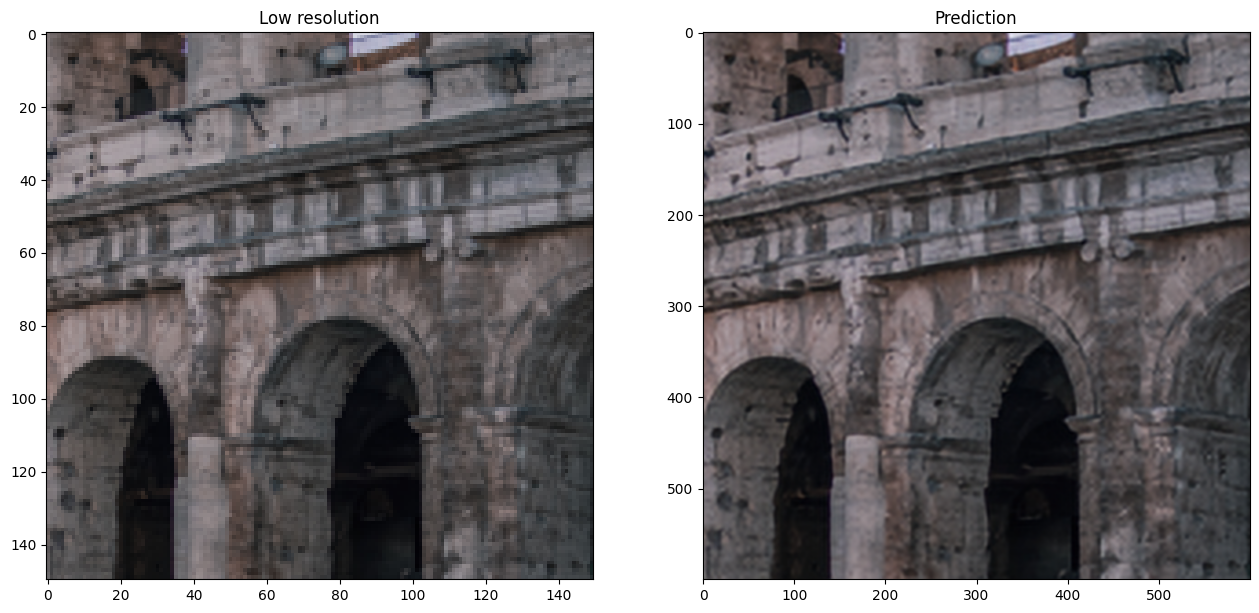

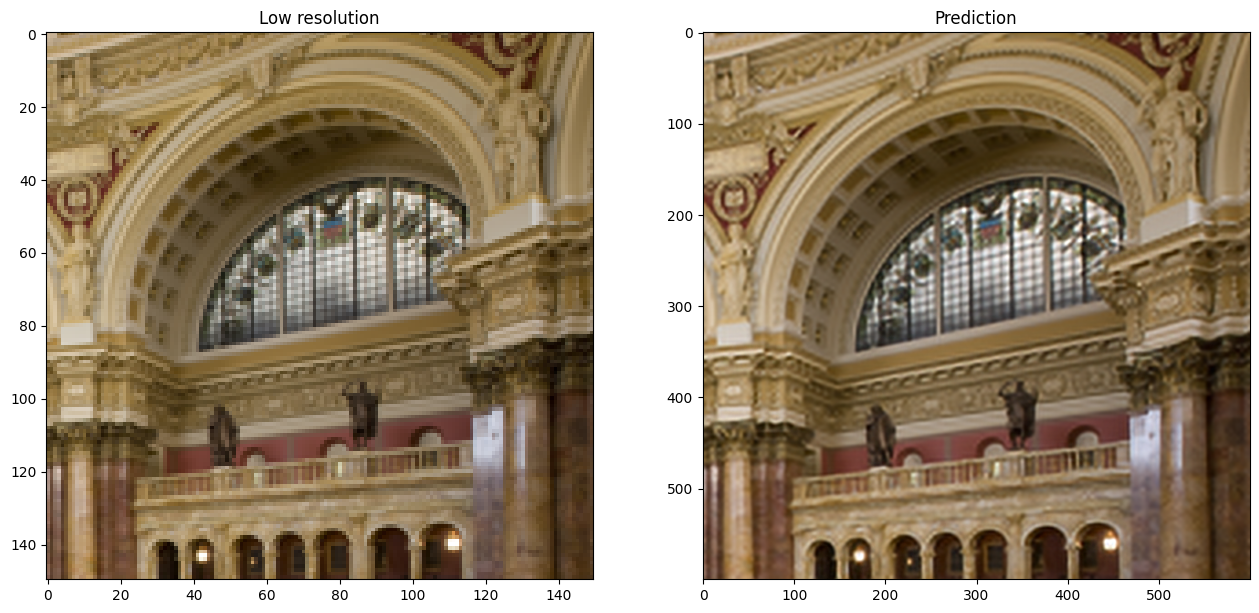

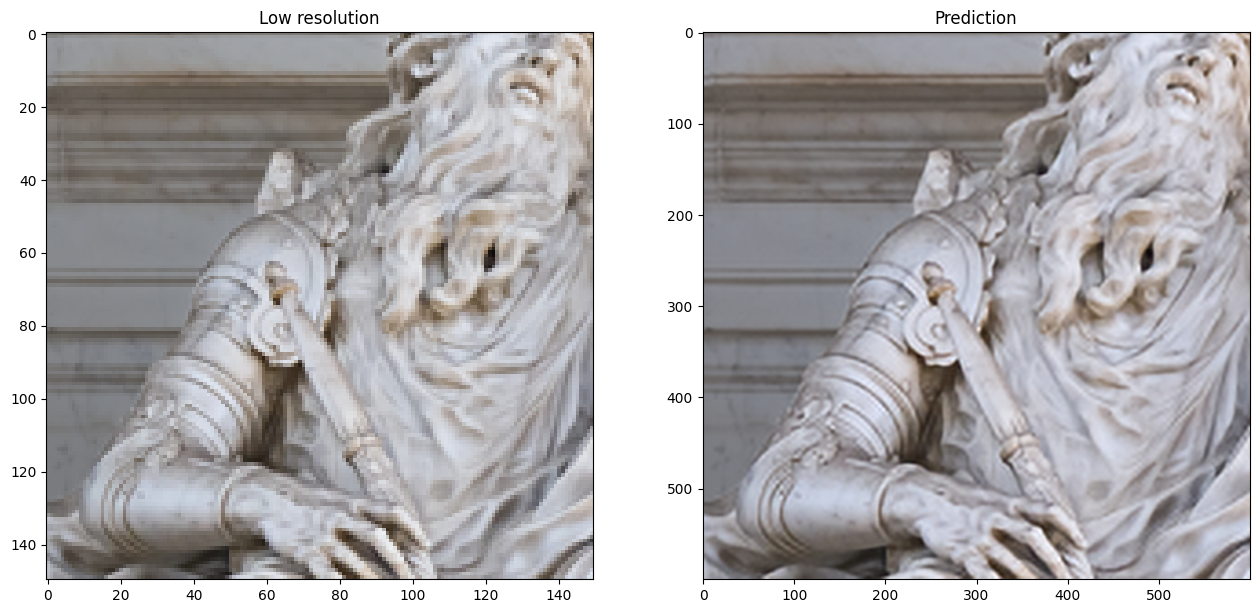

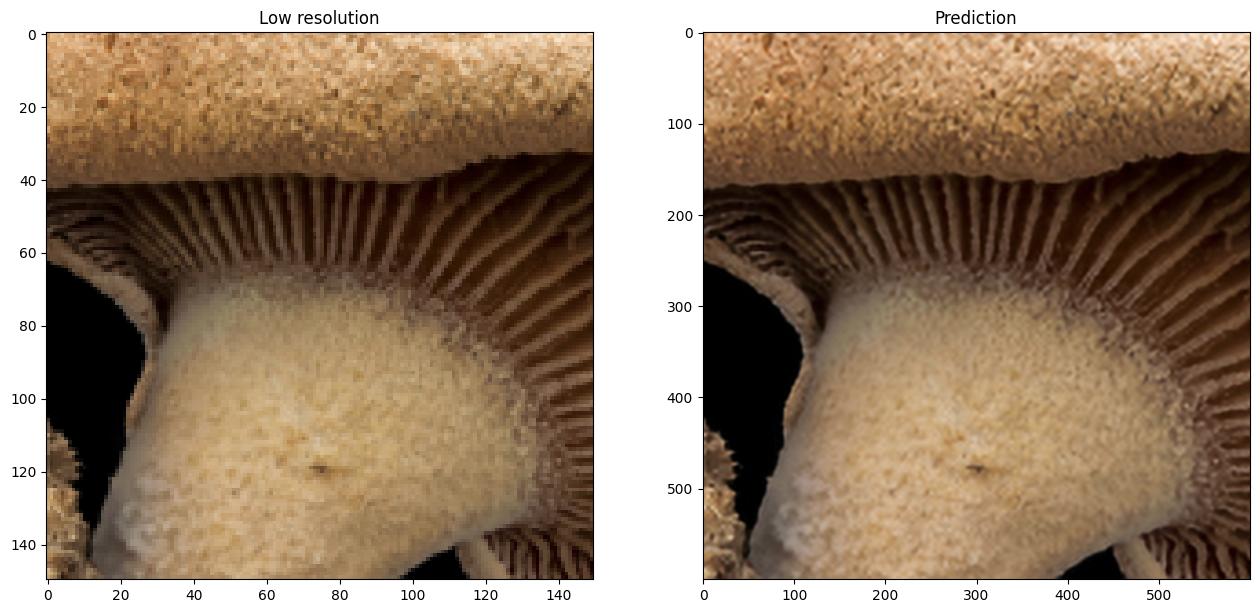

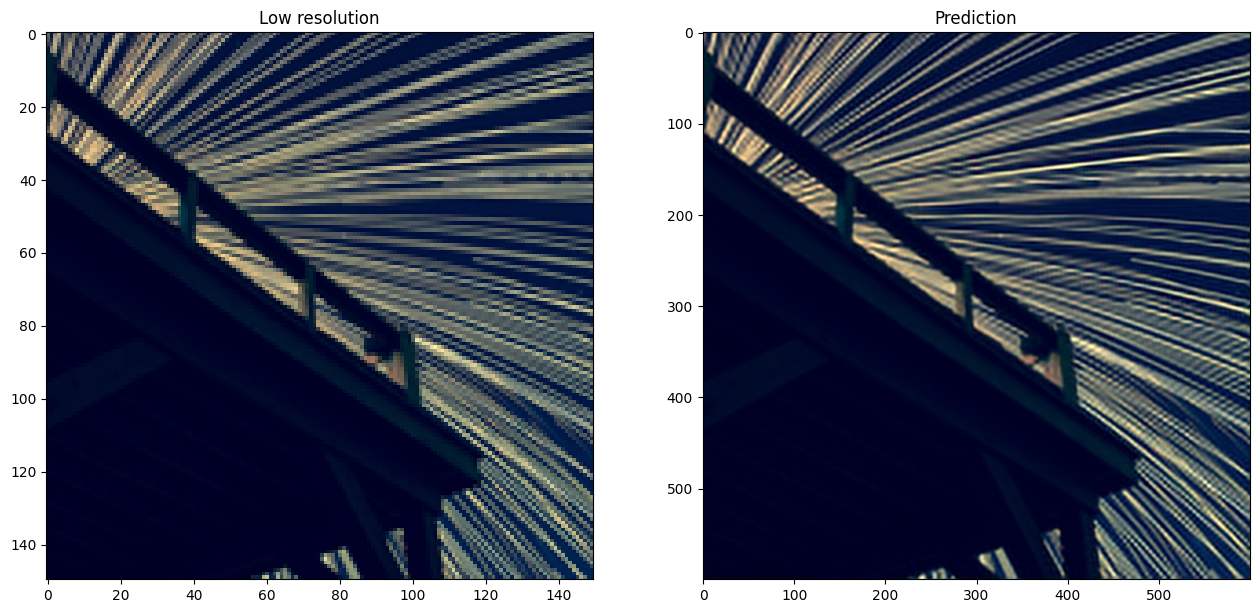

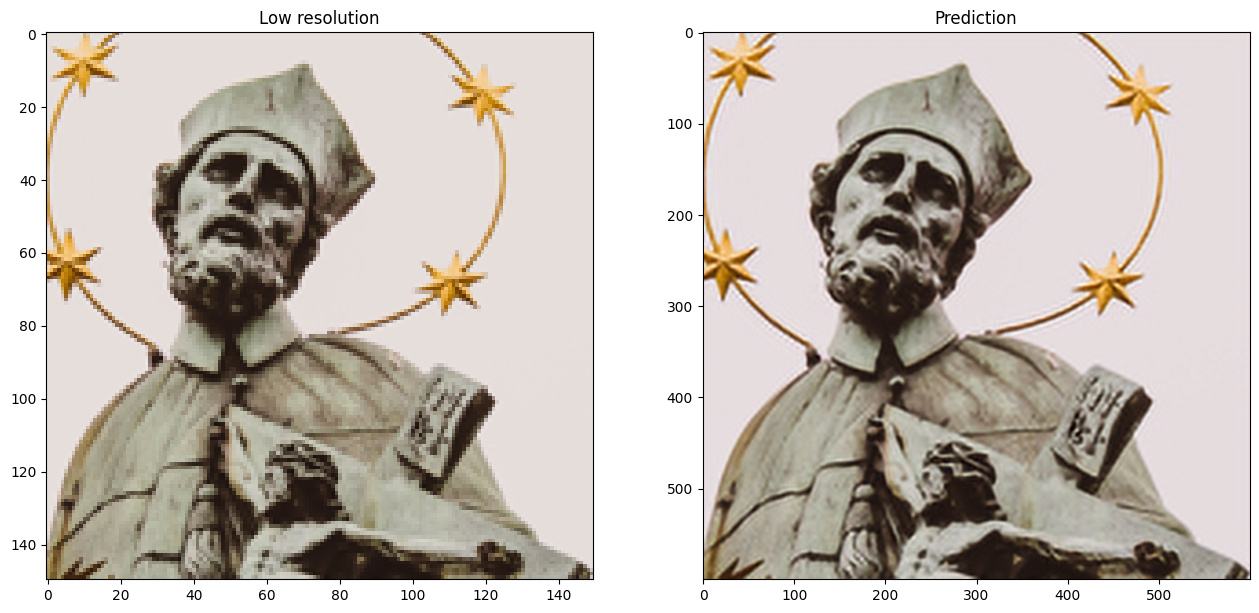

In [59]:
def plot_results(lowres, preds):
    """
    Displays low resolution image and super resolution image
    """
    plt.figure(figsize=(24, 14))
    plt.subplot(132), plt.imshow(lowres), plt.title("Low resolution")
    plt.subplot(133), plt.imshow(preds), plt.title("Prediction")
    plt.show()


for lowres, highres in val.take(10):
    lowres = tf.image.random_crop(lowres, (150, 150, 3))
    preds = model.predict_step(lowres)
    plot_results(lowres, preds)
